# Experiment for House dataset

In [7]:
import sys
import time

sys.path.append('../')

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from tqdm import tqdm

In [9]:
from src import TrackMC, TrackMCDecomp

# Load data

In [10]:
with open('../house_dataset/house_XX.pkl', 'rb') as f:
    XX = pkl.load(f)

# Compare K and MC

## Experiment

In [11]:
params = {
    'K_max': 20,
    'beta': 0.01,
    'random_state': 0,
    'num_em': 10,
    'R': 1e+3,
    'lmd_min': 1e-3,
    'reg_covar': 0.1,
    'verbose': True,
}

In [12]:
track_mc_nml = TrackMC(**params, criterion='NML')
track_mc_nml.fit(XX)

100%|██████████| 96/96 [03:09<00:00,  1.97s/it]


In [13]:
K_nml = track_mc_nml.K_list
mc_nml = track_mc_nml.mc_list(XX)

In [14]:
track_mc_bic = TrackMC(**params, criterion='AIC')
track_mc_bic.fit(XX)

100%|██████████| 96/96 [03:19<00:00,  2.08s/it]


In [15]:
K_bic = track_mc_bic.K_list
mc_bic = track_mc_bic.mc_list(XX)

## Plot

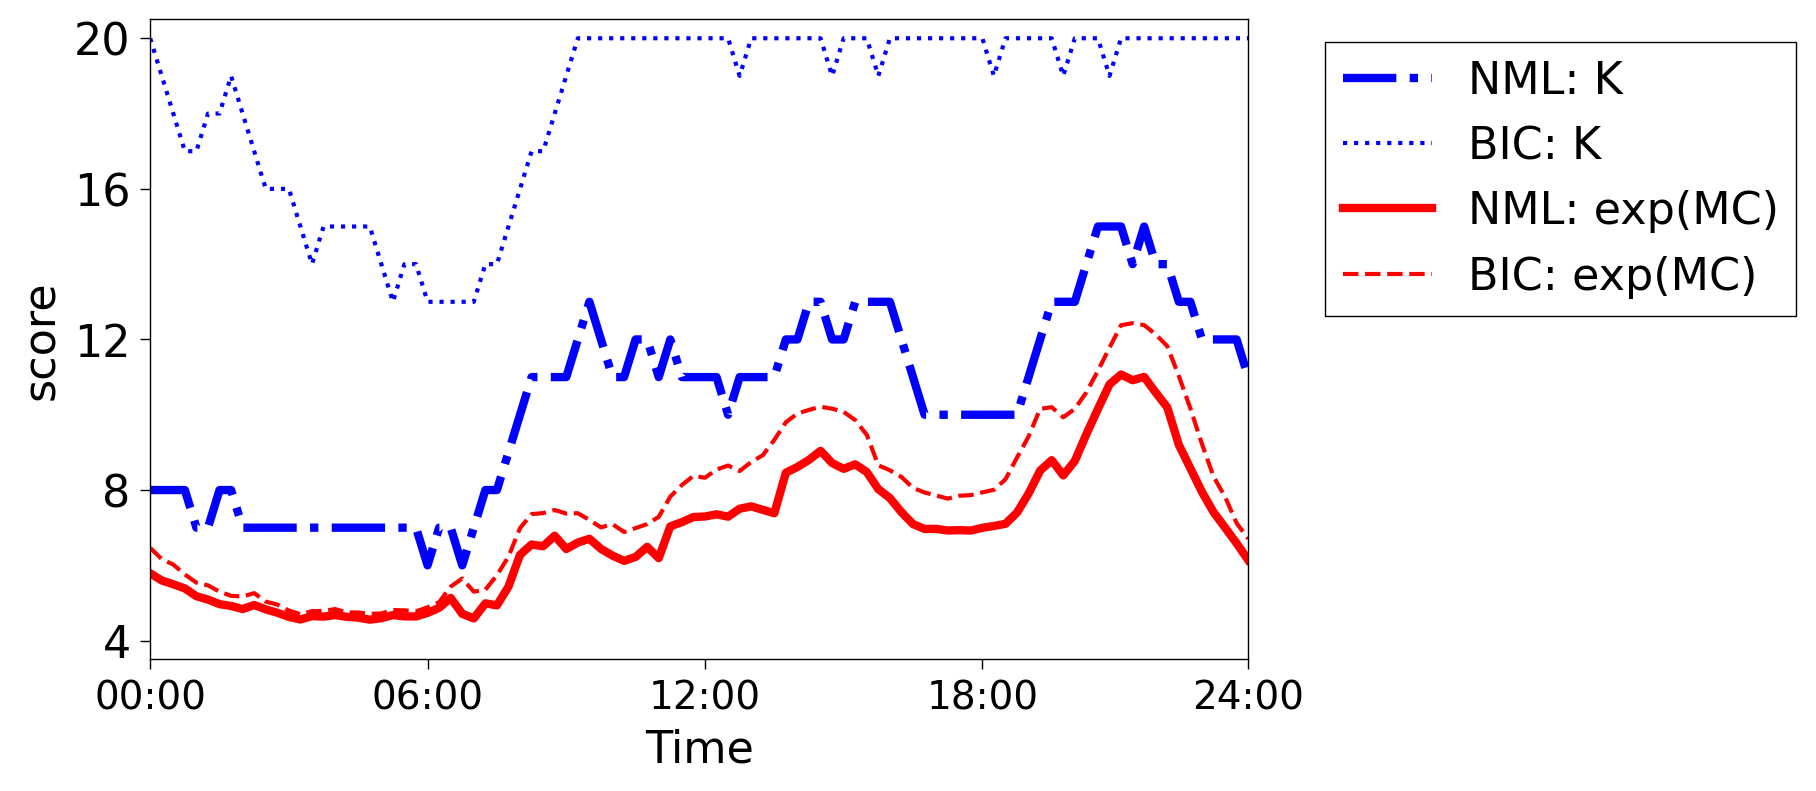

In [16]:
fig, ax = plt.subplots(figsize=(9.0, 4.0), dpi=200)

# plot setting
ax.set_xlim(0, 78)
#####
ymax = 20.5
ymin = 3.5
#####
ax.set_ylim(ymin, ymax)
for a in ['top', 'right', 'bottom', 'left']:
    ax.spines[a].set_linewidth(0.5)
plt.subplots_adjust(top=0.96, right=0.69, left=0.08, bottom=0.16)
ax.tick_params(labelsize=16, width=0.5)
ax.set_xticks([0, 24, 48, 72, 95])
ax.set_xticklabels(['00:00', '06:00', '12:00', '18:00', '24:00'], fontsize=14)
ax.set_yticks([4, 8, 12, 16, 20])
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('score', fontsize=16)
    
# plots
ax.plot(np.arange(96), K_nml, color='blue', linewidth=3.0, linestyle='dashdot', label='NML: K')
ax.plot(np.arange(96), K_bic, color='blue', linewidth=1.5, linestyle='dotted', label='BIC: K')
ax.plot(np.arange(96), np.exp(mc_nml), color='red', linewidth=3.0, linestyle='solid', label='NML: exp(MC)')
ax.plot(np.arange(96), np.exp(mc_bic), color='red', linewidth=1.5, linestyle='dashed', label='BIC: exp(MC)')

ax.legend(
    bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16, fancybox=False, edgecolor="black",
    framealpha=1
).get_frame().set_linewidth(0.5)

plt.show()

# Decomposition

## Experiment

In [11]:
params_decomp = {
    'L': 4,
    'm': 1.5
}

In [12]:
track_mc_decomp = TrackMCDecomp(**params, **params_decomp, criterion='BIC')
track_mc_decomp.fit(XX)

100%|██████████| 96/96 [03:26<00:00,  2.16s/it]


## Plot

In [13]:
def plot_decomp_house(score):
 
    margin = 0.05 * (max(score) - min(score))
    ymax = max(score) + margin
    ymin = min(score) - margin

    # plot setting
    fig, ax = plt.subplots(figsize=(4.5, 1.2), dpi=300)
    ax.set_xlim(0, 95)
    ax.set_ylim(ymin, ymax)
    plt.subplots_adjust(top=0.95, right=0.93, bottom=0.24, left=0.15)
    for a in ['top', 'right', 'bottom', 'left']:
        ax.spines[a].set_linewidth(0.5)
    ax.tick_params(labelsize=14, width=0.5)
    ax.set_xticks([0, 24, 48, 72, 95])
    ax.set_xticklabels(['00:00', '06:00', '12:00', '18:00', '24:00'], fontsize=14)
    ax.set_yticks([min(score), 0.5 * (min(score) + max(score)), max(score)])
    ax.set_yticklabels(['{:.2f}'.format(s) for s in [min(score), 0.5 * (min(score) + max(score)), max(score)]], fontsize=14)

    # plot score
    ax.plot(np.arange(96), score, linewidth=1.0, color='blue')

    plt.show()

### MC(total)

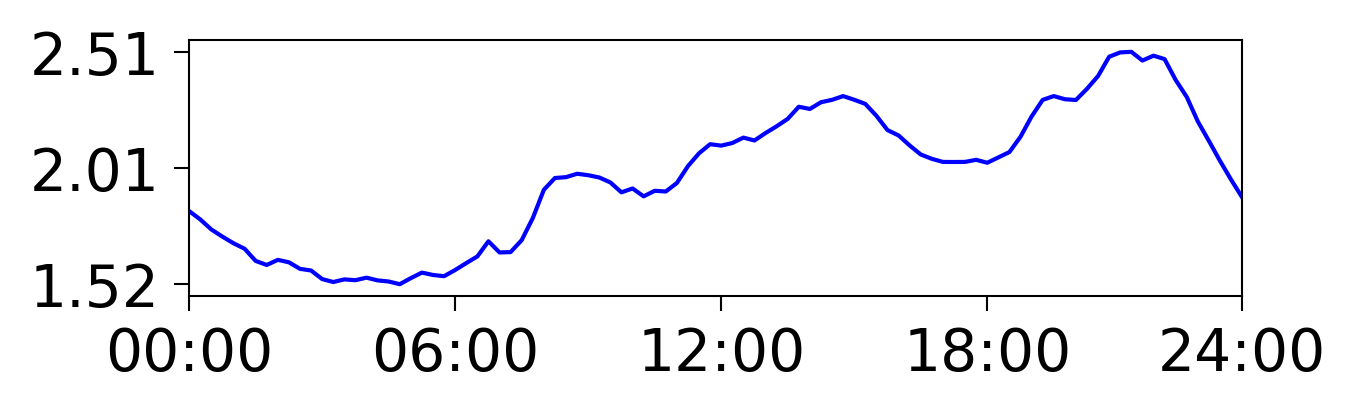

In [14]:
plot_decomp_house(track_mc_decomp.mc_total_)

### MC(interacation)

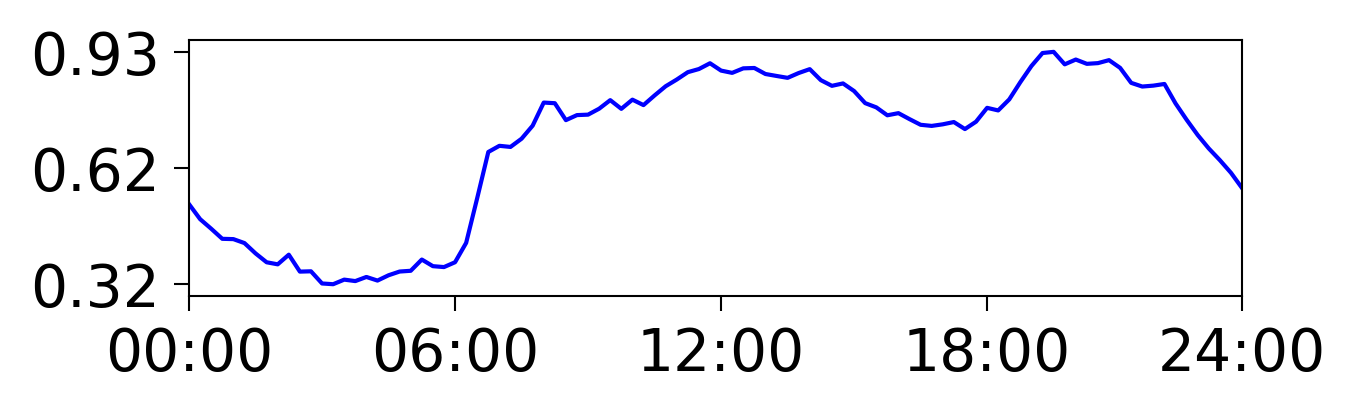

In [15]:
plot_decomp_house(track_mc_decomp.mc_interaction_)

In [16]:
permutation = [2, 1, 0, 3]

### Contribution(cluster l)

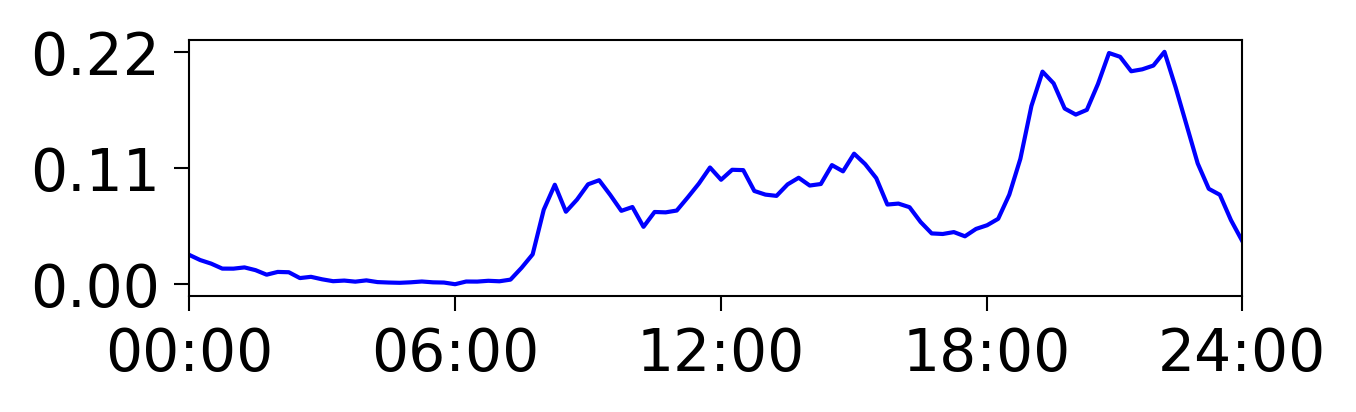

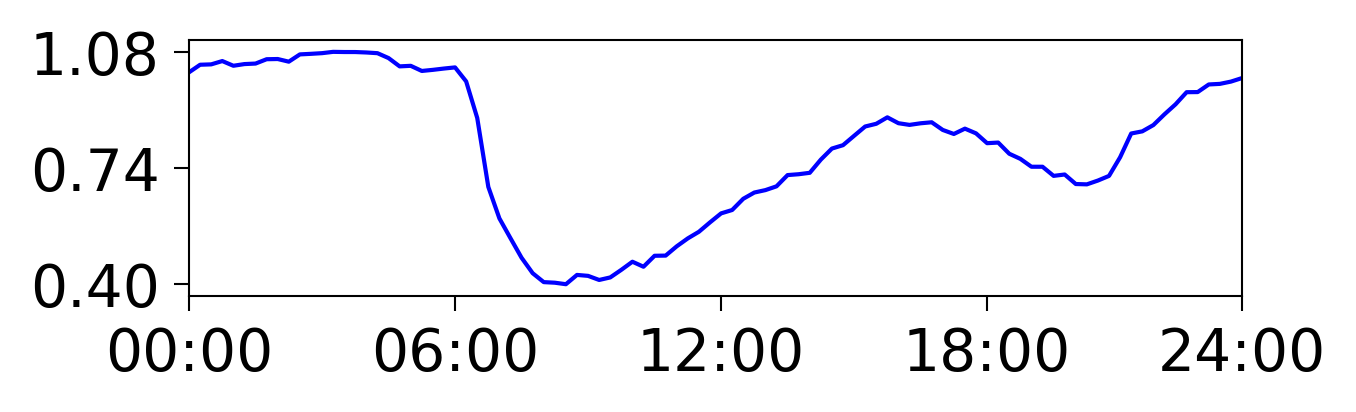

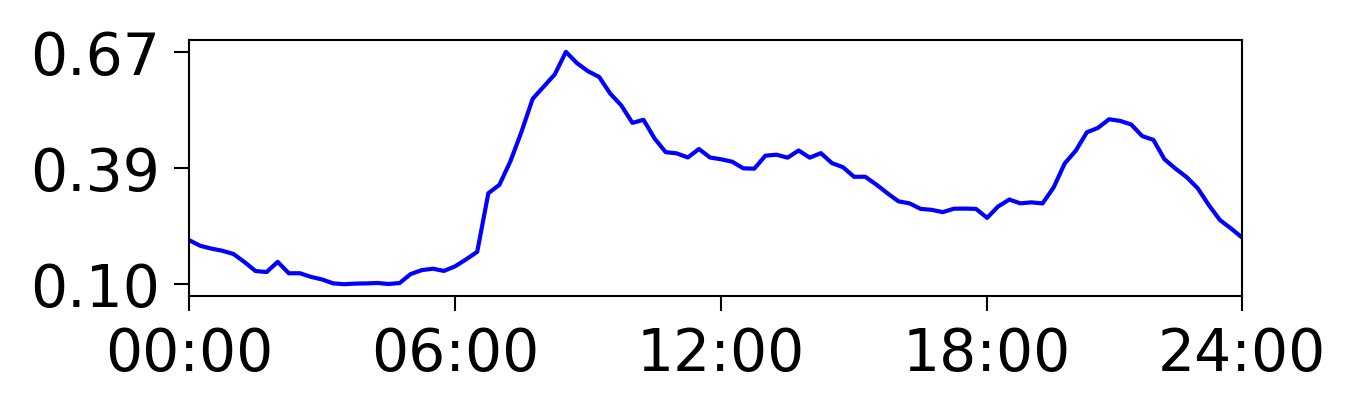

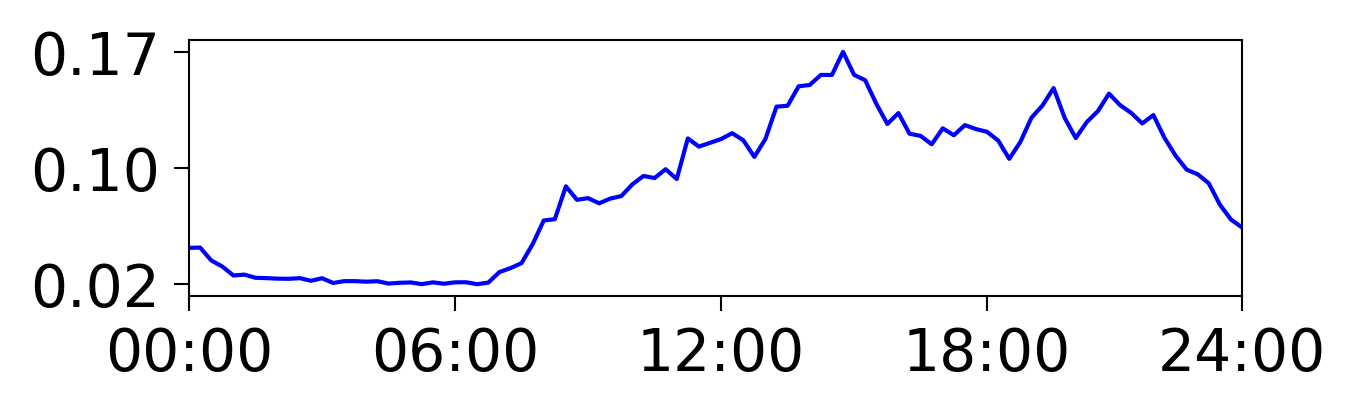

In [17]:
for l in range(4):
    score = track_mc_decomp.mc_local_[:, permutation[l]] * track_mc_decomp.W_[:, permutation[l]]
    plot_decomp_house(score)

### W(cluster l)

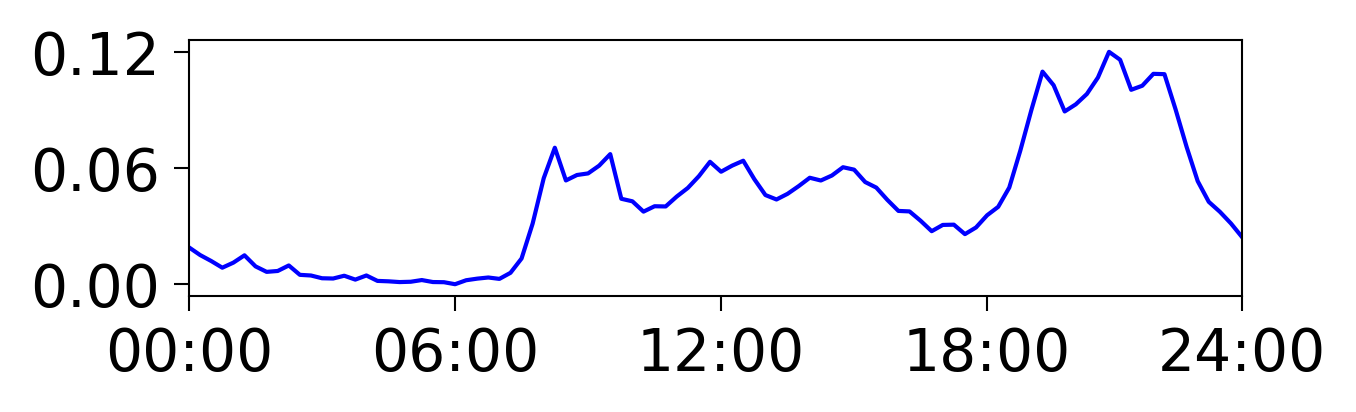

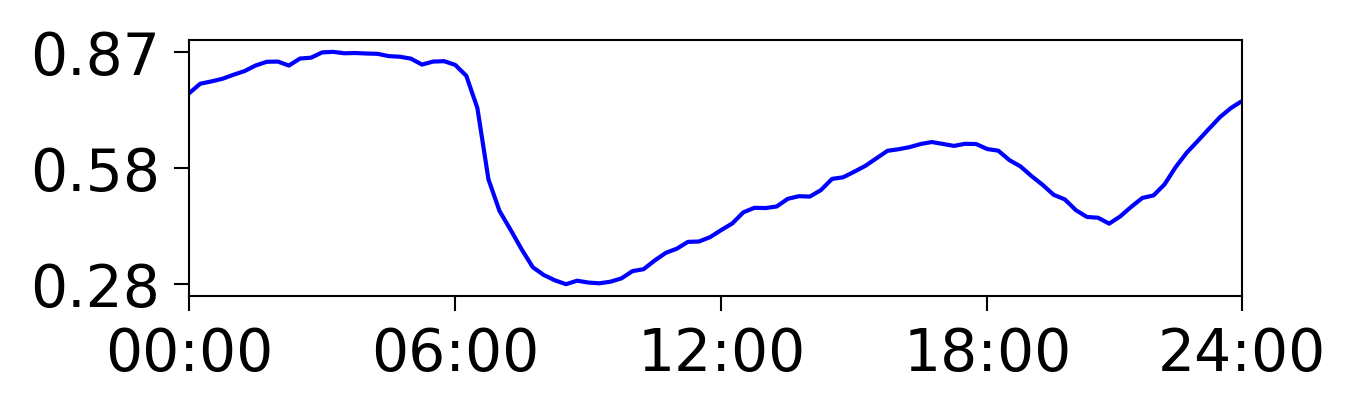

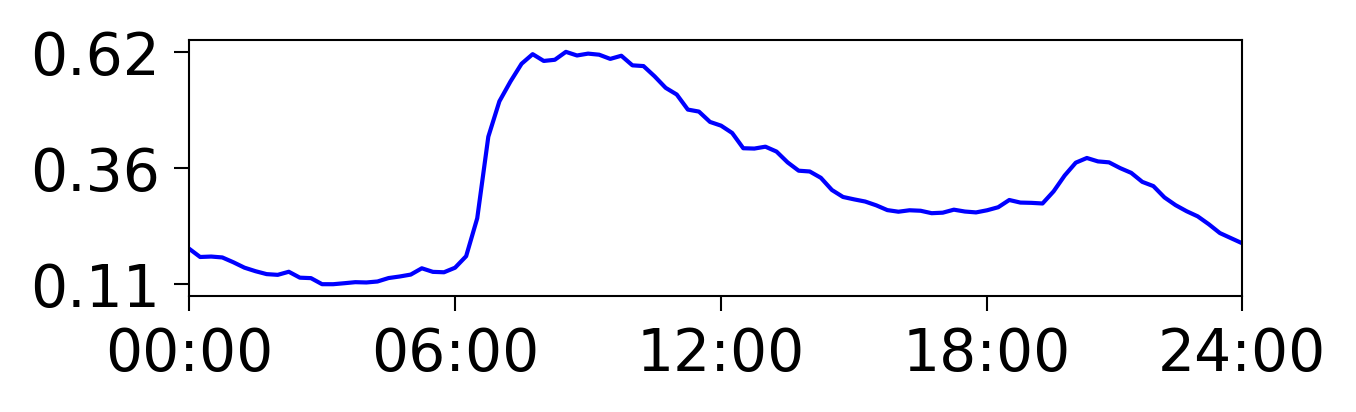

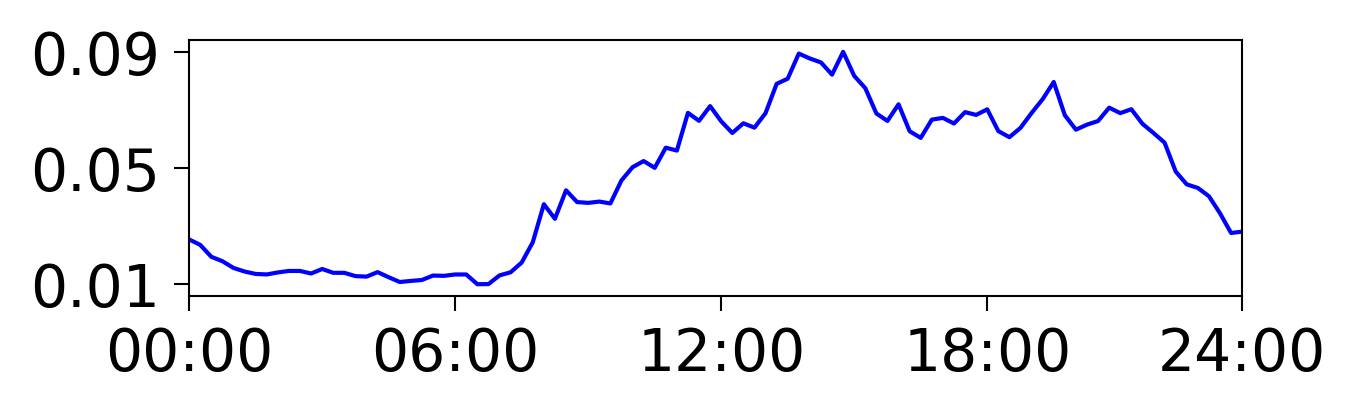

In [18]:
for l in range(4):
    score = track_mc_decomp.W_[:, permutation[l]]
    plot_decomp_house(score)

### MC(cluster l)

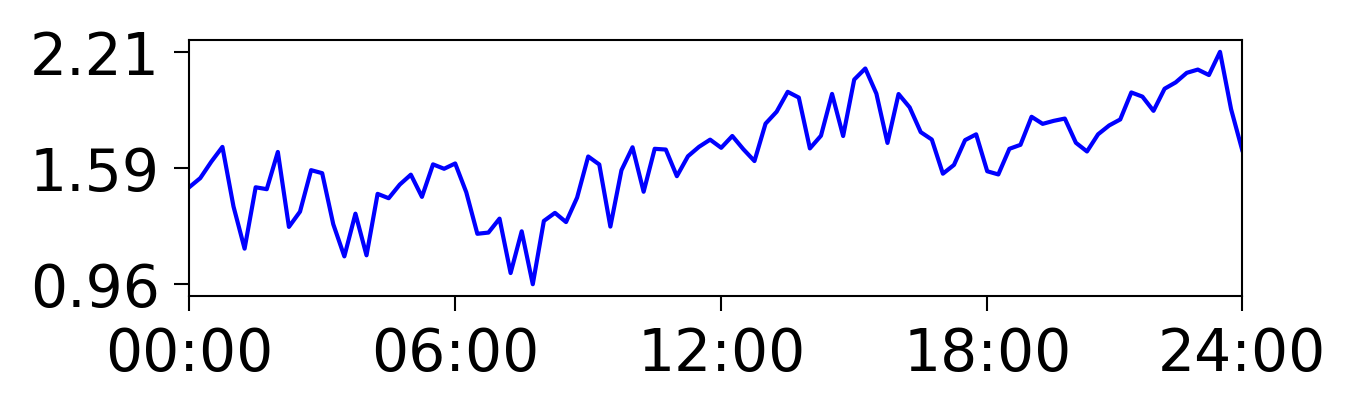

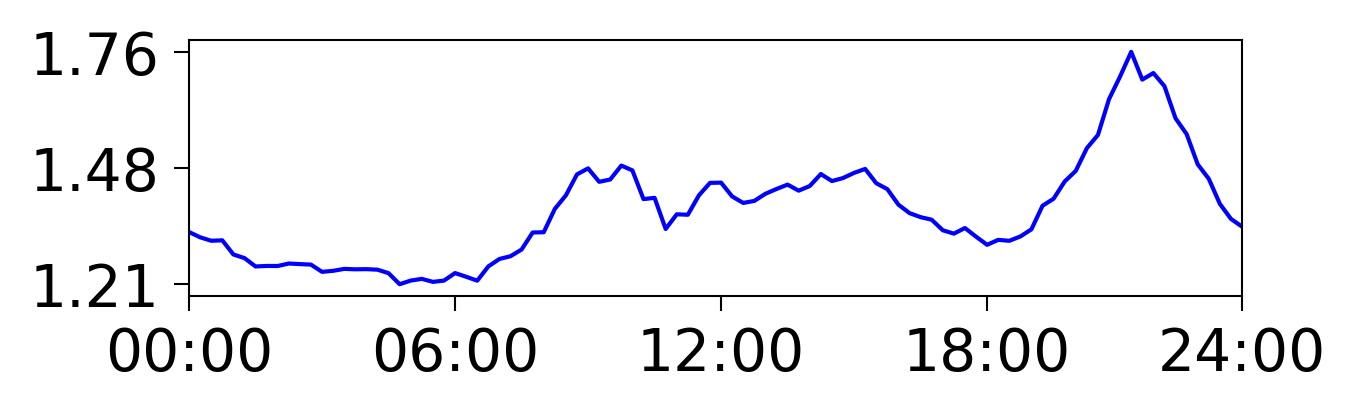

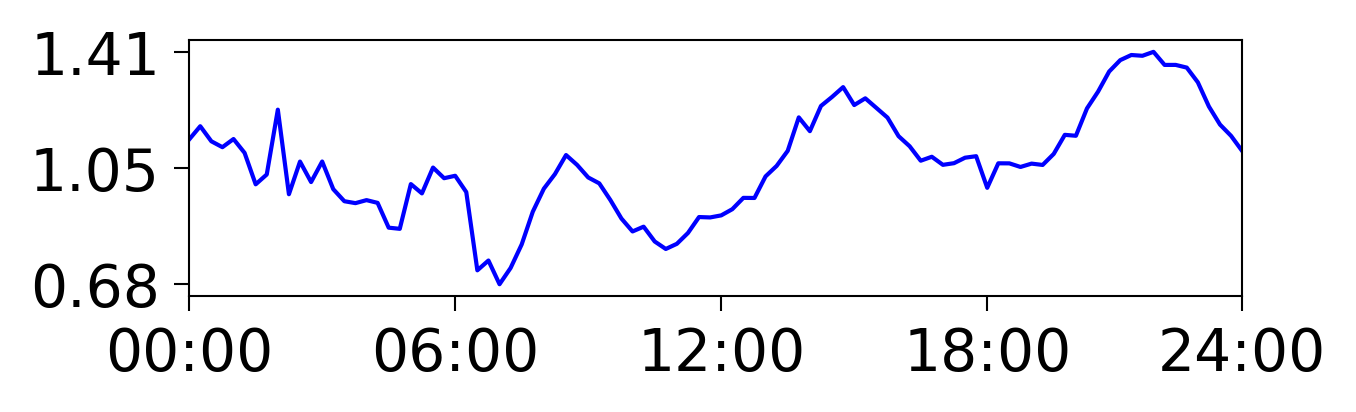

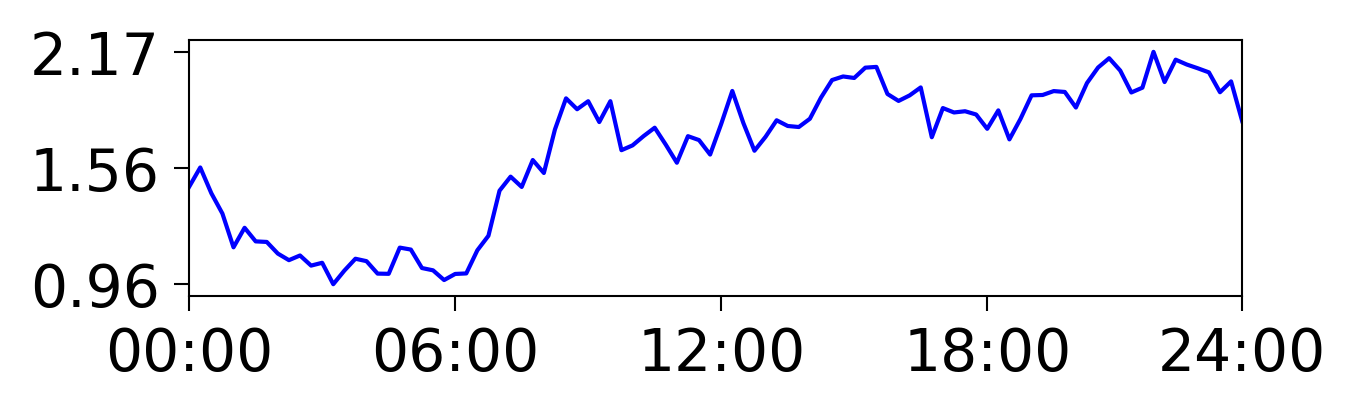

In [19]:
for l in range(4):
    score = track_mc_decomp.mc_local_[:, permutation[l]]
    plot_decomp_house(score)

## Cluster centers to latex

In [20]:
def centers_to_latex(centers, feature_list):
    
    num_cls = len(centers)
    out = ''
    
    # first
    out += '\\begin{tabular}'
    out += '{' + 'r' + '|c' * num_cls + '}'
    out += ' ' + '\\hline \n'
    
    # second
    out += '    '
    for j in range(1, num_cls + 1):
        out += '& component {} '.format(j)
    out += '\\\\ \\hline \n'

    # value
    for i in range(len(feature_list)):
        out += '  '
        out += feature_list[i]
        out += ' '
        for j in range(num_cls):
            out += '& {:.2f} '.format(centers[j, i])
        if i <= len(feature_list) - 2:
            out += '\\\\ \n'   
    
    out += '\\\\ \hline \n'
    
    out += '\\end{tabular}'
    
    return out

In [21]:
centers = track_mc_decomp.centers_[permutation]
features = ['Metering(A)', 'Metering(B)', 'Metering(C)']

print(centers_to_latex(centers, features))

\begin{tabular}{r|c|c|c|c} \hline 
    & component 1 & component 2 & component 3 & component 4 \\ \hline 
  Metering(A) & 4.52 & 0.04 & 0.13 & 0.39 \\ 
  Metering(B) & 0.90 & 0.52 & 0.56 & 4.36 \\ 
  Metering(C) & 3.35 & 0.75 & 4.37 & 2.93 \\ \hline 
\end{tabular}
